# ISPR: midterm 3
## Assignment 5; Chiara De Nigris (mat 586013)
*The dataset contains real and fake news, including their title, text, subject, and date. The objective is to train a binary classifier to recognize fake news. You are free to choose the model's architecture, but you should describe and justify your design choices.
Notice that the fake and real news in the dataset are balanced. However, in the real world, real news are much more frequent than fake ones (hopefully). Simulate the effect of the data imbalance by undersampling/oversampling one of the classes in the training set and compute the test accuracy on a (balanced) test set. Then, try to use a mechanism to make the training robust to imbalances, such as weighting the loss for the samples depending on their class. Discuss the results of this mitigation.*

In [24]:
# imports
import os
import random
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from pandas import DataFrame

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import svm
from sklearn.metrics import classification_report
from sklearn.utils import compute_class_weight
from sklearn.utils import resample
from sklearn.metrics import confusion_matrix

from imblearn.over_sampling import RandomOverSampler

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Dataset

In [3]:
fake = pd.read_csv('/content/drive/MyDrive/ISPR/midterm_3/archive/Fake.csv')
true = pd.read_csv('/content/drive/MyDrive/ISPR/midterm_3/archive/True.csv')

fake['class']='fake'
true['class']='true'

frames = [fake, true]
data = pd.concat(frames)

In [28]:
X = data[['text', 'title', 'date']]
y = data['class']  

# Convert class labels to numerical form
label_mapping = {'fake': 0, 'true': 1}
y = y.map(label_mapping)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

fake    23481
true    21417
Name: class, dtype: int64


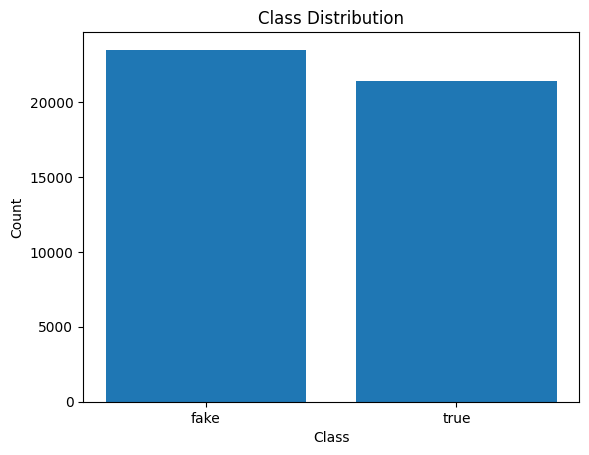

In [4]:
#exploring classes distribution
class_counts = data['class'].value_counts()
plt.bar(class_counts.index, class_counts.values)
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')

print (class_counts)
plt.show()

## Oversampling *True* class in the training set


Using *Sklearn* RandomOversampling method,  it has been oversampled the *True* class in the training data. New oversampled train presents an umbalanced distribution of the classes: 74% of the records are real news, 26% fake news.




In [6]:
oversampler = RandomOverSampler(sampling_strategy={1: 52353})
oversampled_X, oversampled_y = oversampler.fit_resample(X_train, y_train)

oversampled_train = pd.DataFrame(data=oversampled_X, columns=X.columns)
oversampled_train['class'] = oversampled_y

/usr/local/lib/python3.10/dist-packages/imblearn/utils/_validation.py:313: UserWarning: After over-sampling, the number of samples (52353) in class 1 will be larger than the number of samples in the majority class (class #0 -> 18748)
  warnings.warn(


In [7]:
oversampled_train

,text,title,date,class
0,ATHENS (Reuters) - Turkish President Tayyip Er...,Turkey's Erdogan says U.S. Jerusalem decision ...,"December 7, 2017",1
1,"Ted Cruz would be fair, honest and most of all...",BREAKING: Trump Reportedly Considering Ted Cru...,"Nov 15, 2016",0
2,WASHINGTON (Reuters) - White House Chief of St...,Trump chief of staff's Civil War comment spark...,"October 31, 2017",1
3,DUBAI (Reuters) - Saudi Arabia welcomed the ne...,Saudi Arabia welcomes new U.S. strategy toward...,"October 13, 2017",1
4,"SIGONELLA, Italy (Reuters) - U.S. President Do...",Trump arrives in Sicily ahead of Group of Seve...,"May 25, 2017",1
...,...,...,...,...
71096,(Reuters) - The U.S. Labor Department on Wedne...,U.S. Labor Department rescinds Obama-era rule ...,"June 7, 2017",1
71097,UNITED NATIONS (Reuters) - The United Nations ...,Outgoing U.S. envoy says U.N. needs to 'push' ...,"January 18, 2017",1
71098,WASHINGTON (Reuters) - U.S. Defense Secretary ...,U.S. response to Russia hacking 'not the end':...,"January 10, 2017",1
71099,MANILA/WASHINGTON (Reuters) - Philippines lead...,"Duterte says felt rapport with Trump, assures ...","December 2, 2016",1


true    52353
fake    18748
Name: class, dtype: int64


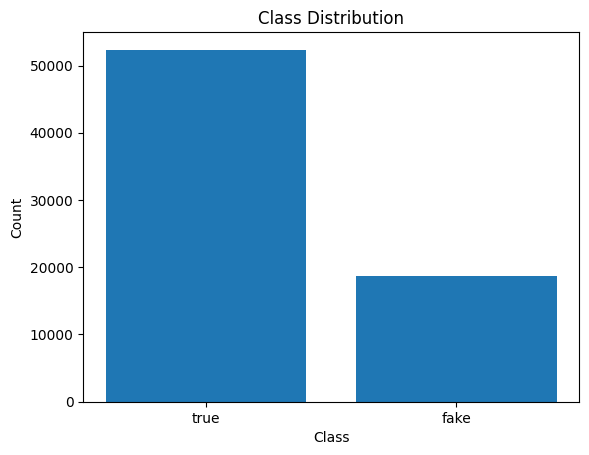

In [8]:
#exploring new classes distribution
#remapping labels into string to visualization reason in the graph
oversampled_train['class'] = oversampled_train['class'].map({0: 'fake', 1: 'true'})
ov_class_counts = oversampled_train['class'].value_counts()
plt.bar(ov_class_counts.index, ov_class_counts.values)
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')

print (ov_class_counts)
plt.show()

In [9]:
oversampled_train['class'] = oversampled_train['class'].map({'fake': 0, 'true': 1})

In [10]:
X_train_ov = oversampled_train[['text', 'title', 'date']]
y_train_ov = oversampled_train['class']

# News classification o oversampled training set using SVM

To classify news it has been choosen to use *Support Vector Machines* classifier because of it speed and because it generalizes well in high dimensional spaces (like to textual ones). To convert the text data into numerical features that can be used by the classifier, it has been used the *CountVectorizer* *scikit-learn's* module. 

In [14]:
vectorizer = CountVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train_ov['text'])

In [15]:
# Train the SVM classifier
svm_classifier = svm.SVC()
svm_classifier.fit(X_train_vectorized, y_train_ov)

SVC()

In [16]:
X_test_vectorized = vectorizer.transform(X_test['text'])
y_pred = svm_classifier.predict(X_test_vectorized)

In [17]:
classification_rep = classification_report(y_test, y_pred)
print("Classification Report:")
print(classification_rep)

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      4733
           1       0.99      1.00      0.99      4247

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



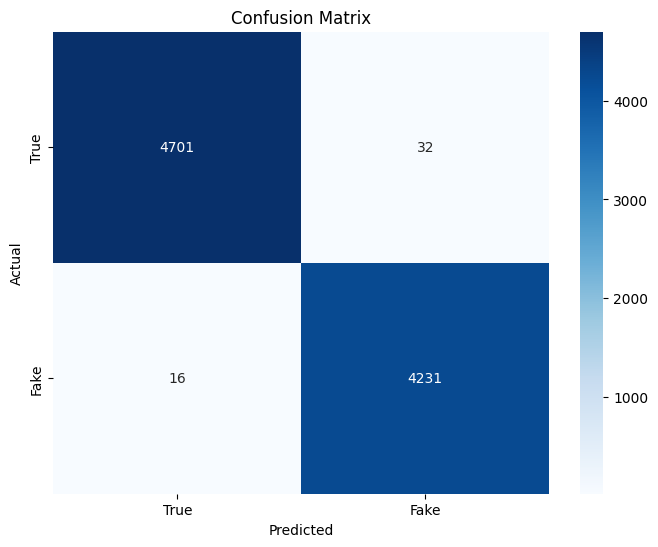

In [25]:
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, index=['True', 'Fake'], columns=['True', 'Fake'])

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

From the moment that results are already excellent, I tried to undersample the fake class in the training set ad unbalance it even more.

## Undersampling *Fake* class in the training set

In [37]:
from imblearn.under_sampling import RandomUnderSampler

undersampler = RandomUnderSampler(sampling_strategy={0: 1000})
undersampled_X, undersampled_y = undersampler.fit_resample(X_train, y_train)

undersampled_train = pd.DataFrame(data=undersampled_X, columns=X_train.columns)
undersampled_train['class'] = undersampled_y

true    17170
fake     1000
Name: class, dtype: int64


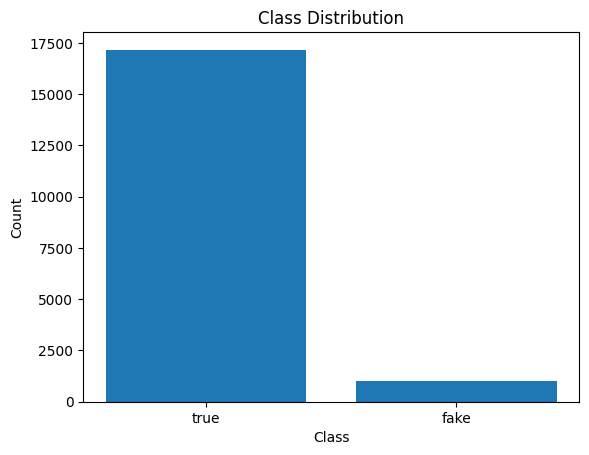

In [38]:
undersampled_train['class'] = undersampled_train['class'].map({0: 'fake', 1: 'true'})

us_class_counts = undersampled_train['class'].value_counts()

plt.bar(us_class_counts.index, us_class_counts.values)
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')

print(us_class_counts)

plt.show()

In [39]:
undersampled_train['class'] = undersampled_train['class'].map({'fake': 0, 'true': 1})

X_train_us = undersampled_train[['text', 'title', 'date']]
y_train_us = undersampled_train['class']

## News classification on undersampled training set usig SVM

In [40]:
X_train_vectorized_us = vectorizer.fit_transform(X_train_us['text'])

In [41]:
# Train the SVM classifier
svm_classifier_us = svm.SVC()
svm_classifier_us.fit(X_train_vectorized_us, y_train_us)

SVC()

In [48]:
X_test_vectorized = vectorizer.transform(X_test['text'])
y_pred_us = svm_classifier_us.predict(X_test_vectorized)

In [49]:
classification_rep = classification_report(y_test, y_pred_us)
print("Classification Report:")
print(classification_rep)

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.72      0.83      4733
           1       0.76      1.00      0.86      4247

    accuracy                           0.85      8980
   macro avg       0.88      0.86      0.85      8980
weighted avg       0.89      0.85      0.85      8980



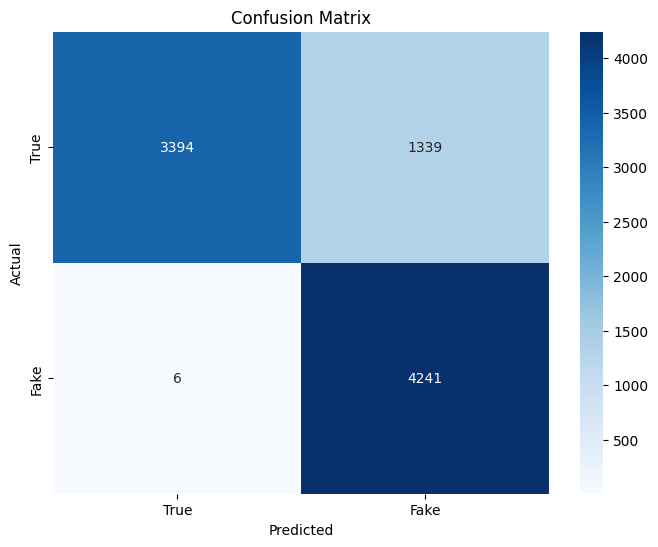

In [53]:
cm = confusion_matrix(y_test, y_pred_us)
cm_df = pd.DataFrame(cm, index=['True', 'Fake'], columns=['True', 'Fake'])

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## Make SVM robust to imabalance

Even if results are suprisingly still very good, , to address the data imbalance issue in  dataset they have been used class weighting. By assigning higher weights to the minority class (fake news) it is possible to ensure that the model pays more attention to this class during training.

The class weights have been calculated based on the class distribution in the training dataset using the compute_class_weigth sklearn class

In [50]:
class_weights = compute_class_weight('balanced', classes=[0, 1], y=y_train_us)
class_weights = {label: weight for label, weight in enumerate(class_weights)}

print(class_weights)

{0: 9.085, 1: 0.529120559114735}


During the training of the SVM classifier, class weights are passed as a parameter to give higher importance to the minority class (fake news) samples.

In [51]:
svm_classifier_cw = svm.SVC(class_weight={0: class_weights[0], 1: class_weights[1]})
svm_classifier_cw.fit(X_train_vectorized_us, y_train_us)

y_pred_cw = svm_classifier_cw.predict(X_test_vectorized)

In [52]:
classification_rep_cw = classification_report(y_test, y_pred_cw)
print("Classification Report:")
print(classification_rep_cw)

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.92      0.96      4733
           1       0.91      1.00      0.95      4247

    accuracy                           0.95      8980
   macro avg       0.96      0.96      0.95      8980
weighted avg       0.96      0.95      0.95      8980



## Conclusions

The initial results obtained with SVM trained on an unbalanced training set are already surprisingly good, indicating the potential of the model. However, due to the class imbalance, the classifier may not be effectively capturing the patterns in the minority class.
To address this issue, they havew been incorporated class weights as a parameter in the SVM model. By assigning higher weights to the minority class, we allow the classifier to pay more attention to correctly predicting instances from that class. With the increased focus on the minority class, the SVM model demonstrated enhanced accuracy and better recall for identifying fake news.
